In [ ]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image
import base64
import PIL

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

from IPython.display import clear_output
import importlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### set up paths

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
gallery_dir = os.path.abspath(os.path.join(proj_dir,'gallery'))

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir,sketch_dir,gallery_dir]]

## add utils to python path
import sys
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))
import utils

### establish connection to mongo
first thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

ssh -fNL 27020:127.0.0.1:27017 USER@cogtoolslab.org

In [ ]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['iterated_number']
coll = db['animals']

# which iteration name should we use?
iterationName = 'livetest0' #increment when needed

In [ ]:
## here is what one of these records looks like
coll.find_one()

### Initialize dataframes

In [ ]:
## trials
k = coll.find({'iterationName':iterationName, 'eventType':'clickedObj'})
K = pd.DataFrame(k)

## strokes
t = coll.find({'iterationName':iterationName, 'eventType':'stroke'})
T = pd.DataFrame(t)

In [9]:
## get list of valid game IDs (i.e, subject number)
from collections import Counter
game_dict = Counter(K['gameid']) ## get dictionary mapping gameIDs to number of sketches 
complete_gameids = [k for (k,v) in game_dict.items() if v==24] ## get gameids that contributed exactly 6 sketches

In [12]:
## subset stroke/sketch dataframes by being complete AND also exclude practice
subset = True
if (subset and T['gameid'].nunique()!=len(complete_gameids)):
    T = T[(T['gameid'].isin(complete_gameids))].reset_index(drop=True)
    K = K[(K['gameid'].isin(complete_gameids))].reset_index(drop=True)
    
print('We have {} unique stroke records in all {} of our complete games.'.format(T.shape[0],len(complete_gameids)))
print('We have {} unique sketch records in all {} of our complete games.'.format(K.shape[0],len(complete_gameids)))

We have 90 unique stroke records in all 1 of our complete games.
We have 24 unique sketch records in all 1 of our complete games.


In [ ]:
## save out to csv
T.to_csv(os.path.join(csv_dir,'photodraw_stroke_data.csv'),index=False)
K.to_csv(os.path.join(csv_dir,'photodraw_sketch_data.csv'),index=False)

### render out all the sketches

In [ ]:
importlib.reload(utils)
utils.render_images(K,data = 'pngString',
                    metadata = ['gameid','intendedName','trialNum'],
                    out_dir = sketch_dir)

### make sketch gallery

Generating sketch gallery for participant: 4757-9a59ed9d-3cae-410e-b760-11df2488f69d | 1 of 2
Generating sketch gallery for participant: 9157-c9264032-2b49-4daf-b817-0e28360058b8 | 2 of 2


ValueError: num must be 1 <= num <= 12, not 13

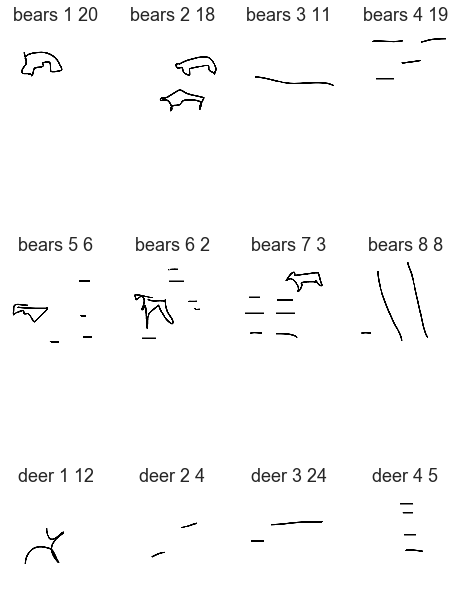

In [ ]:
reallyRun = 1
if reallyRun:
    sketch_paths = sorted([sketch_path for sketch_path in os.listdir(sketch_dir)])
    gameids = list(np.unique([i.split('_')[0] for i in sketch_paths]))

    ## generate gallery for each participant
    for gind, game in enumerate(gameids): 
        print('Generating sketch gallery for participant: {} | {} of {}'.format(game,gind+1,len(gameids)))
        # get list of all sketch paths JUST from current game
        game_sketch_paths = [path for path in sketch_paths if path.split('_')[0] == game]
        fig = plt.figure(figsize=(8,12))   
        for i,f in enumerate(game_sketch_paths):
            # open image
            im = Image.open(os.path.join(sketch_dir,f))
            # get metadata
            gameid = f.split('_')[0] 
            trialNum = f.split('_')[1]
            condition = f.split('_')[2]
            category = f.split('_')[3].split('.')[0]   
            # make gallery
            p = plt.subplot(3,4,i+1)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([])   
            p.axis('off')
            plt.title('{} {} {}'.format(trialNum,condition,category))
        plt.suptitle(gameid)
        fname = '{}.png'.format(gameid)
        plt.savefig(os.path.join(gallery_dir,fname))
        plt.close(fig)
    print('Done!')